This notebook contains scripts to compare plume model codes with differences in the choice of conserved variable


In [1]:
import importlib
import PlumeModel
from preprocessors import preprocess_ARMBE, preprocess_Nauru
import time
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr


In [2]:
importlib.reload(PlumeModel)

<module 'PlumeModel' from '/home/fiaz/plume_model/PlumeModel.py'>

In [3]:
input_dir = Path('/neelin2020/ARM/CACTI/')
time_str = 'corinterpolatedsondeM1.c1.20181018'
fil_interpsonde = [str(i) for i in (input_dir/'interpsonde').glob(time_str+'*.nc')]
fil_interpsonde.sort()
fil_interpsonde

['/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181018.000030.nc']

(1000.0, 0.0)

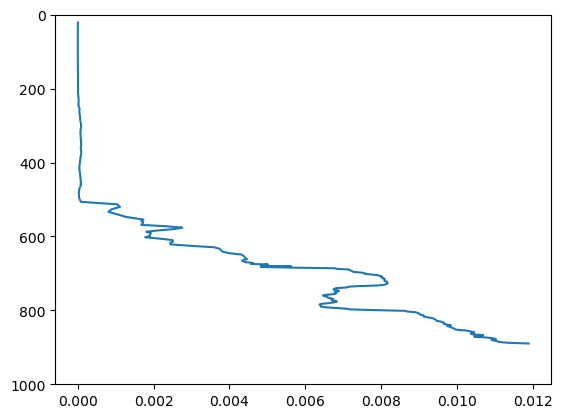

In [4]:
# select a single profile for testing
import xarray as xr
def preprocess_interpsonde_CACTI(fils):
    ds = xr.open_mfdataset(fils)
    ts = slice('2018-10-18T17:00:00', '2018-10-18T17:30:00')
    ds = ds.sel(time = ts)
    return ds.temp.values + 273, ds.sh.values, ds.bar_pres.values * 1e1, ds.time.values

ds = preprocess_interpsonde_CACTI(fil_interpsonde)
plt.plot(ds[1][0, :], ds[2][0, :])
plt.ylim(1000, 0)


In [17]:
output_dir = './'  # directory to save the output files
output_file_name = 'plume_props_CACTI_test_theta_il'  # name of the output file
kwargs = dict(fils = fil_interpsonde, 
              preprocess = preprocess_interpsonde_CACTI,
              output_file_name = output_file_name, 
              output_dir = output_dir, 
              launch_opt = 'specified',  # specified level or from the surface
              launch_level = 885,        # launch level in hPa
              rain_out = 1e2,            # rain out threshold (kg/kg)
              conserved = 1,            # 1: theta_il, 2: theta_e
              DIB_mix_upper = 450,       # upper level for DIB mixing; no mixing above this level
              microphysics = 2, 
              mix_opt = 'NOMIX',         # mixing option: 'DIB' or 'NOMIX'
              C0 = 0.2)

pm = PlumeModel.PlumeModel(**kwargs)

pm.preprocess_data()
pm.mixing_coefficients()
stime = time.time()
pm.run_plume(mix = pm.mix_opt)
print(f'Done. Took {time.time()-stime: .3f} seconds')
pm.postprocess_save()

RUNNING NOMIX PLUME COMPUTATION
Done. Took  0.015 seconds
SAVING FILE
File saved as plume_props_CACTI_test_theta_il.nc


In [113]:
importlib.reload(PlumeModel)
kwargs.update(output_file_name = 'plume_props_CACTI_test_mse-ib')
jp_pm = PlumeModel.JPPlume(**kwargs)
jp_pm.prepare_jp_plume()
jp_pm.lift_parcel_adiabatic(jp_pm.fracent, jp_pm.prate)
jp_pm.postprocess_save()

SAVING FILE
File saved as plume_props_CACTI_test_mse-ib.nc


In [119]:
# Code to test the lifted parcel temperature
# import ECAPE_FUNCTIONS
# importlib.reload(ECAPE_FUNCTIONS)
# from ECAPE_FUNCTIONS import lift_parcel_adiabatic
# ds0 = xr.open_dataset('plume_props_CACTI_test_mse-ib.nc').isel(time = 0)
# T_jp, *_ = lift_parcel_adiabatic(ds0.T_env.values, ds0.lev.values * 1e2, ds0.q_env.values, jp_pm.ind_launch[0], 0, 0, jp_pm.z[0,:], jp_pm.T1, jp_pm.T2)

In [18]:
fil_out = pm.output_file_name.with_suffix('.nc')
ds = xr.open_dataset(fil_out)
files = [i for i in Path(output_dir).glob('*plume_props_CACTI_test_*.nc')]
ds = {i.stem.split('test_')[-1] : xr.open_mfdataset(i) for i in files}

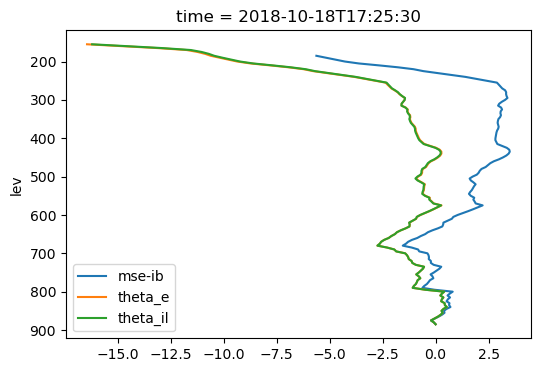

In [19]:
plot_Tdiff = lambda ds, it, ax, label: (ds.T_plume - ds.T_env).isel(time = it).plot(y = 'lev', yincrease = False, 
                                                                                    ax = ax, label = label)
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for k in ds.keys():
    plot_Tdiff(ds[k], 25, ax, label = k )
ax.legend()

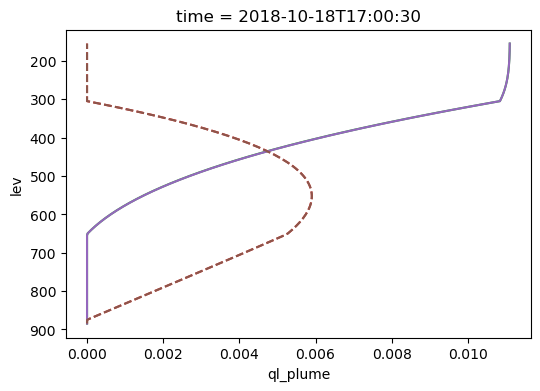

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for k in ds.keys():
    ds[k].qi_plume.isel(time = 0).plot(y = 'lev', yincrease = False, ax = ax, label = k)
    ds[k].ql_plume.isel(time = 0).plot(y = 'lev', yincrease = False, ax = ax, label = k, linestyle = '--')

(1000.0, 400.0)

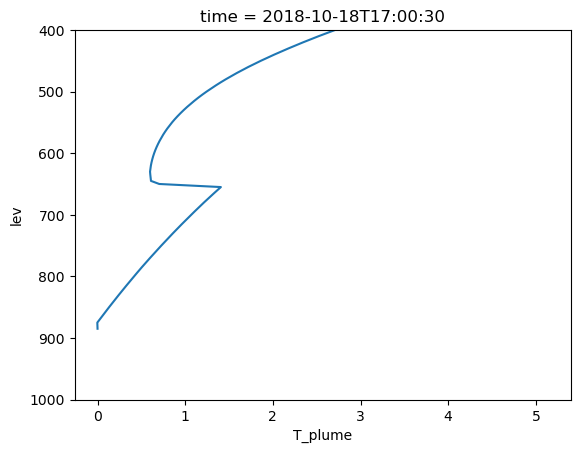

In [131]:
( ds['mse-ib'].T_plume - ds['theta_il'].T_plume ).isel(time = 0).plot(y = 'lev', yincrease = False, label = 'mse-ib - theta_il')
plt.ylim(1000, 400)

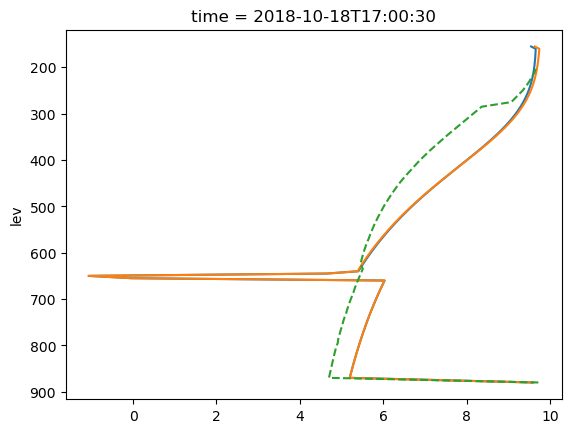

In [ ]:
# lapse rate
def compute_lapse_rate(ds):
    dp = ds.lev.differentiate('lev')
    RD = 287.04
    GRAVITY = 9.81
    dpdz = -(ds.lev) * GRAVITY / (RD * ds.Tv_plume)
    lapse_rate = -ds.T_plume.differentiate('lev') * dpdz * 1e3 # K/km
    return lapse_rate

lr = {k : compute_lapse_rate(ds[k]) for k in ds.keys()}
# lapse_rate_theta_e = compute_lapse_rate(ds['theta_e'])
# lapse_rate_theta_il = compute_lapse_rate(ds['theta_il'])

# dp = ds_theta_il.lev.differentiate('lev')
# RD = 287.04
# GRAVITY = 9.81
# dpdz = -(ds_theta_il.lev) * GRAVITY / (RD * ds_theta_il.Tv_plume)
# lapse_rate = -ds_theta_il.T_plume.differentiate('lev') * dpdz * 1e3 # K/km

(lr['theta_il']).isel(time = 0).plot(y = 'lev', yincrease = False)
(lr['theta_e']).isel(time = 0).plot(y = 'lev', yincrease = False)
(lr['mse-ib']).isel(time = 0).plot(y = 'lev', yincrease = False, linestyle =  '--')
